<a href="https://colab.research.google.com/github/pedro00pt/Projeto-de-Big-Data/blob/main/Projeto_de_Big_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Projeto de Big Data

#Realizado por:
#Pedro Peixoto nº202000221
#João Yanga nº202000167

In [2]:
!pip install pyspark
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 12.7 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=a272e429bc968bbdb3981fd17c3461ad83b5087d950474451c9bd952428bbdc8
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
# We can also make use of datatypes from 
# pyspark.sql.types
from datetime import datetime
from pyspark.sql.functions import col, udf, count, asc, desc
from pyspark.sql.types import DoubleType, IntegerType, DateType, FloatType



from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import col,isnan, when, count



from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors



from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.mllib.clustering import KMeans



from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

from pyspark.ml.feature import StandardScaler

In [4]:
from pyspark.sql import SparkSession
import findspark

findspark.init()

spark = SparkSession.builder.appName("Projeto de Big Data")\
                    .config("spark.memory.offHeap.enabled","true")\
                    .config("spark.memory.offHeap.size","10g")\
                    .getOrCreate()


# check spark configuration

spark

In [6]:
#modificação do csv original para conseguir ter dados em colunas diferentes

!curl https://raw.githubusercontent.com/pedro00pt/Projeto-de-Big-Data/main/bank_transactions-colunas_alinhadas.csv >> bank_transactions-colunas_alinhadas.csv
df = spark.read.csv('bank_transactions-colunas_alinhadas.csv',header=True,sep=";")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 66.8M  100 66.8M    0     0  21.4M      0  0:00:03  0:00:03 --:--:-- 21.4M


In [7]:
df.head(10)

[Row(TransactionID='T1', CustomerID='C5841053', CustomerDOB='10/1/94', CustGender='F', CustLocation='JAMSHEDPUR', CustAccountBalance='17819.05', TransactionDate='02/08/2016', TransactionTime='143207', TransactionAmount (INR)='25'),
 Row(TransactionID='T2', CustomerID='C2142763', CustomerDOB='4/4/57', CustGender='M', CustLocation='JHAJJAR', CustAccountBalance='2270.69', TransactionDate='02/08/2016', TransactionTime='141858', TransactionAmount (INR)='27999'),
 Row(TransactionID='T3', CustomerID='C4417068', CustomerDOB='26/11/96', CustGender='F', CustLocation='MUMBAI', CustAccountBalance='17874.44', TransactionDate='02/08/2016', TransactionTime='142712', TransactionAmount (INR)='459'),
 Row(TransactionID='T4', CustomerID='C5342380', CustomerDOB='14/9/73', CustGender='F', CustLocation='MUMBAI', CustAccountBalance='866503.21', TransactionDate='02/08/2016', TransactionTime='142714', TransactionAmount (INR)='2060'),
 Row(TransactionID='T5', CustomerID='C9031234', CustomerDOB='24/3/88', CustGe

In [8]:
df.show(5,0)

+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|TransactionID|CustomerID|CustomerDOB|CustGender|CustLocation|CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount (INR)|
+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|T1           |C5841053  |10/1/94    |F         |JAMSHEDPUR  |17819.05          |02/08/2016     |143207         |25                     |
|T2           |C2142763  |4/4/57     |M         |JHAJJAR     |2270.69           |02/08/2016     |141858         |27999                  |
|T3           |C4417068  |26/11/96   |F         |MUMBAI      |17874.44          |02/08/2016     |142712         |459                    |
|T4           |C5342380  |14/9/73    |F         |MUMBAI      |866503.21         |02/08/2016     |142714         |2060                   |
|T5           |C9031234  |24/3/88 

In [9]:
df = df \
    .withColumn('CustomerDOB', col('CustomerDOB').cast(DateType())) \
    .withColumn('CustAccountBalance', col('CustAccountBalance').cast(FloatType())) \
    .withColumn('TransactionDate', col('TransactionDate').cast(DateType())) \
    .withColumn('TransactionTime', col('TransactionTime').cast(IntegerType())) \
    .withColumn('TransactionAmount (INR)', col('TransactionAmount (INR)').cast(FloatType()))

In [10]:
df.count()

1048567

In [11]:
#para ver se tem nulls
df_Columns=["TransactionID","CustomerID","CustGender","CustLocation","CustAccountBalance","TransactionTime","TransactionAmount (INR)"]
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df_Columns]).show()

+-------------+----------+----------+------------+------------------+---------------+-----------------------+
|TransactionID|CustomerID|CustGender|CustLocation|CustAccountBalance|TransactionTime|TransactionAmount (INR)|
+-------------+----------+----------+------------+------------------+---------------+-----------------------+
|            0|         0|      1100|         151|              2369|              0|                      0|
+-------------+----------+----------+------------+------------------+---------------+-----------------------+



In [12]:
#para ver se tem na's
df_Columns=["TransactionID","CustomerID","CustGender","CustLocation","CustAccountBalance","TransactionTime","TransactionAmount (INR)"]
df.select([count(when(isnan(c), c)).alias(c) for c in df_Columns]).show()

+-------------+----------+----------+------------+------------------+---------------+-----------------------+
|TransactionID|CustomerID|CustGender|CustLocation|CustAccountBalance|TransactionTime|TransactionAmount (INR)|
+-------------+----------+----------+------------+------------------+---------------+-----------------------+
|            0|         0|         0|           0|                 0|              0|                      0|
+-------------+----------+----------+------------+------------------+---------------+-----------------------+



In [13]:
from pyspark.sql.functions import col

df = df.filter(col("CustAccountBalance").isNotNull())   #para retirar os nulls

In [14]:
from pyspark.sql.functions import col

df = df.filter(col("CustLocation").isNotNull())         #para retirar os nulls

In [15]:
df.describe().show()

+-------+-------------+----------+----------+--------------------+------------------+------------------+-----------------------+
|summary|TransactionID|CustomerID|CustGender|        CustLocation|CustAccountBalance|   TransactionTime|TransactionAmount (INR)|
+-------+-------------+----------+----------+--------------------+------------------+------------------+-----------------------+
|  count|      1046047|   1046047|   1044947|             1046047|           1046047|           1046047|                1046047|
|   mean|         null|      null|      null|            400012.0|115406.95782476036|157094.47744795406|     1573.2621233532354|
| stddev|         null|      null|      null|                 0.0|  846544.952151457|  51263.3503468519|      6570.077431588658|
|    min|           T1|  C1010011|         F|(154) BHASKOLA FA...|               0.0|                 0|                    0.0|
|    max|      T999999|  C9099956|         T|           ZUNHEBOTO|      1.15035496E8|            

In [16]:
df.printSchema()

root
 |-- TransactionID: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- CustomerDOB: date (nullable = true)
 |-- CustGender: string (nullable = true)
 |-- CustLocation: string (nullable = true)
 |-- CustAccountBalance: float (nullable = true)
 |-- TransactionDate: date (nullable = true)
 |-- TransactionTime: integer (nullable = true)
 |-- TransactionAmount (INR): float (nullable = true)



In [17]:
print(dict(df.dtypes)['CustAccountBalance'] )

float


In [18]:
print(dict(df.dtypes)['TransactionID'] )

string


In [19]:
df.select('CustomerID').distinct().count()

882486

In [20]:
df_id_CustomerID = df.select('CustomerID')

In [21]:
df_id_CustomerID.show(3)

+----------+
|CustomerID|
+----------+
|  C5841053|
|  C2142763|
|  C4417068|
+----------+
only showing top 3 rows



In [22]:
df.columns

['TransactionID',
 'CustomerID',
 'CustomerDOB',
 'CustGender',
 'CustLocation',
 'CustAccountBalance',
 'TransactionDate',
 'TransactionTime',
 'TransactionAmount (INR)']

In [23]:
df_id_CustGender = df.select('CustGender')

In [24]:
df_id_CustGender.show(10)

+----------+
|CustGender|
+----------+
|         F|
|         M|
|         F|
|         F|
|         F|
|         F|
|         F|
|         M|
|         F|
|         M|
+----------+
only showing top 10 rows



In [25]:
new_df_CustAccountBalanceBiggerThan5000 = df.filter(df.CustAccountBalance > 5000)
new_df_CustAccountBalanceBiggerThan5000.show(10)

+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|TransactionID|CustomerID|CustomerDOB|CustGender|CustLocation|CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount (INR)|
+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|           T1|  C5841053|       null|         F|  JAMSHEDPUR|          17819.05|           null|         143207|                   25.0|
|           T3|  C4417068|       null|         F|      MUMBAI|          17874.44|           null|         142712|                  459.0|
|           T4|  C5342380|       null|         F|      MUMBAI|          866503.2|           null|         142714|                 2060.0|
|           T5|  C9031234|       null|         F| NAVI MUMBAI|           6714.43|           null|         181156|                 1762.5|
|           T6|  C1536588|       n

In [26]:
new_df_TransactionTimeLessThan500 = df.filter(df.TransactionTime < 500)
new_df_TransactionTimeLessThan500.show(10)

+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|TransactionID|CustomerID|CustomerDOB|CustGender|CustLocation|CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount (INR)|
+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|        T5126|  C1214190|       null|         F|        DURG|            401.44|           null|            400|                  110.0|
|       T20397|  C3222875|       null|         M|  VIJAYAWADA|          16511.74|           null|             10|                  330.0|
|       T21305|  C6228180|       null|         M|    DINDIGUL|             70.09|           null|            113|                   10.0|
|       T35040|  C8916035|       null|         M|   BANGALORE|          19298.99|           null|            357|                1538.81|
|       T35041|  C6432239|       n

In [27]:
df.select('CustGender').distinct().count()

4

In [28]:
new_df_PessoasPorSexo = df.groupby('CustGender')
new_df_PessoasPorSexo.count().show(10)

+----------+------+
|CustGender| count|
+----------+------+
|         F|281241|
|      null|  1100|
|         M|763705|
|         T|     1|
+----------+------+



In [29]:
new_df_CustLocation = df.groupby('CustLocation')
new_df_CustLocation.count().show(20)

+--------------------+-----+
|        CustLocation|count|
+--------------------+-----+
|             GWALIOR|  947|
|      UTTAR DINAJPUR|   62|
|             SANGRUR|  352|
|  ACADEMY SAMASTIPUR|    5|
|NO 3 NR LALLAN HO...|   57|
|GATE DARIYAPUR AH...|    7|
|ELPHINSTONE W MUMBAI|   12|
|             SHIMOGA|  114|
|          FLOOR PUNE|    2|
|           TIRUVALLA|    8|
|        SARAN CHAPRA|    3|
|             MOHANIA|    2|
|              TEEKOY|   10|
|CUMBALLA HILL MUMBAI|    2|
|            KANUBARI|   24|
|          NALAPPURAM|    5|
|B/H ATM UNION BAN...|    5|
|  TIRUPATI NGR THANE|    2|
|            K K DIST|   10|
|              SUBBAL|    3|
+--------------------+-----+
only showing top 20 rows



In [30]:
df.groupBy('CustLocation').agg(countDistinct('CustomerID').alias('count')).orderBy(desc('count')).show(10)

+------------+------+
|CustLocation| count|
+------------+------+
|      MUMBAI|101473|
|   NEW DELHI| 83371|
|   BANGALORE| 80264|
|     GURGAON| 72788|
|       DELHI| 69870|
|       NOIDA| 32493|
|     CHENNAI| 29749|
|        PUNE| 25632|
|   HYDERABAD| 22889|
|       THANE| 21336|
+------------+------+
only showing top 10 rows



In [31]:
df.createOrReplaceTempView("Top10AccountBalance")
query = '''SELECT CustomerID, CustGender, CustLocation, CustAccountBalance FROM Top10AccountBalance ORDER BY CustAccountBalance DESC'''
spark.sql(query).show(80)

+----------+----------+------------+------------------+
|CustomerID|CustGender|CustLocation|CustAccountBalance|
+----------+----------+------------+------------------+
|  C3316830|         M|    SHILLONG|      1.15035496E8|
|  C6416825|         M|    SHILLONG|      1.15035496E8|
|  C4316889|         M|    SHILLONG|      1.15035496E8|
|  C2216823|         M|    SHILLONG|      1.15035496E8|
|  C5916881|         M|    SHILLONG|      1.15035496E8|
|  C5116828|         M|    SHILLONG|      1.15035496E8|
|  C2916887|         M|    SHILLONG|      1.15035496E8|
|  C7716886|         M|    SHILLONG|      1.15035496E8|
|  C2916865|         M|    SHILLONG|      1.15035496E8|
|  C8116818|         M|    SHILLONG|      1.15035496E8|
|  C5914453|         F|     GURGAON|       8.2244632E7|
|  C2514473|         F|     GURGAON|       8.2244632E7|
|  C4014424|         F|     GURGAON|       8.2244632E7|
|  C6914429|         F|     GURGAON|       8.2244632E7|
|  C3414471|         F|     GURGAON|       8.224

In [32]:
#alteração do nome da coluna: de TransactionAmount (INR) para TransactionAmount 

df = df.withColumnRenamed('TransactionAmount (INR)', 'TransactionAmount')

In [33]:
df.printSchema()

root
 |-- TransactionID: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- CustomerDOB: date (nullable = true)
 |-- CustGender: string (nullable = true)
 |-- CustLocation: string (nullable = true)
 |-- CustAccountBalance: float (nullable = true)
 |-- TransactionDate: date (nullable = true)
 |-- TransactionTime: integer (nullable = true)
 |-- TransactionAmount: float (nullable = true)



In [34]:
df.describe().toPandas()

,summary,TransactionID,CustomerID,CustGender,CustLocation,CustAccountBalance,TransactionTime,TransactionAmount
0,count,1046047,1046047,1044947,1046047,1046047,1046047,1046047
1,mean,None,None,None,400012.0,115406.95782476036,157094.47744795406,1573.2621233532354
2,stddev,None,None,None,0.0,846544.952151457,51263.3503468519,6570.077431588658
3,min,T1,C1010011,F,(154) BHASKOLA FARIDABAD,0.0,0,0.0
4,max,T999999,C9099956,T,ZUNHEBOTO,1.15035496E8,235959,1560035.0


In [35]:
#from pyspark.ml.feature import VectorAssembler
#df.columns
#assemble=VectorAssembler(inputCols=[
 #   'CustAccountBalance',
 #   'TransactionAmount'], outputCol='features')
#assembled_data=assemble.transform(df)
#assembled_data.show(2)

In [36]:
#from pyspark.ml.feature import StandardScaler
#scale=StandardScaler(inputCol='features',outputCol='standardized')
#data_scale=scale.fit(assembled_data)
#data_scale_output=data_scale.transform(assembled_data)
#data_scale_output.show(2)

In [37]:
#from pyspark.ml.feature import Normalizer

# Cria uma instância de Normalizer
#normalizer = Normalizer(inputCol="vector_features", outputCol="normalized_features", p=2.0)

# Aplica a normalização
#normalized_df = normalizer.transform(df)

In [38]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

# Cria um vetor assembler para combinar as colunas "CustAccountBalance" e "TransactionAmount" em um único vetor
vectorAssembler = VectorAssembler(inputCols=["CustAccountBalance", "TransactionAmount"], outputCol="unscaled_features")

# Utiliza o vetor assembler para transformar o DataFrame
df_kmeans = vectorAssembler.transform(df)

# Cria um objeto de escalonamento para standardizar os dados
scaler = StandardScaler(inputCol="unscaled_features", outputCol="features", withStd=True, withMean=True)

# Ajusta o escalonador aos dados e transforma o DataFrame
scalerModel = scaler.fit(df_kmeans)
df_kmeans = scalerModel.transform(df_kmeans)

# Instancia o modelo KMeans com o número de clusters desejado
kmeans = KMeans(k=3, seed=1)

# Ajusta o modelo aos dados
model = kmeans.fit(df_kmeans)

# Faz a previsão dos clusters
predictions = model.transform(df_kmeans)

# Exibe os resultados
predictions.select("CustAccountBalance", "TransactionAmount","prediction").show()

+------------------+-----------------+----------+
|CustAccountBalance|TransactionAmount|prediction|
+------------------+-----------------+----------+
|          17819.05|             25.0|         0|
|           2270.69|          27999.0|         0|
|          17874.44|            459.0|         0|
|          866503.2|           2060.0|         0|
|           6714.43|           1762.5|         0|
|           53609.2|            676.0|         0|
|            973.46|            566.0|         0|
|          95075.54|            148.0|         0|
|          14906.96|            833.0|         0|
|           4279.22|           289.11|         0|
|          48429.49|            259.0|         0|
|          14613.46|            202.0|         0|
|          32274.78|          12300.0|         0|
|          59950.44|             50.0|         0|
|          10100.84|            338.0|         0|
|           1283.12|            250.0|         0|
|          77495.15|          1423.11|         0|


In [39]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import LinearRegression

# Criando o vetor de características
assembler = VectorAssembler(inputCols=["CustAccountBalance", "TransactionAmount"], outputCol="features")
df = assembler.transform(df)

# Standardizando as colunas
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scalerModel = scaler.fit(df)
df = scalerModel.transform(df)

# Criando o modelo de regressão linear
lr = LinearRegression(featuresCol = "scaled_features", labelCol='TransactionAmount')
lrModel = lr.fit(df)
predictions = lrModel.transform(df)


In [40]:
summary = lrModel.summary
print("RMSE:", summary.rootMeanSquaredError)
print("R-squared:", summary.r2)
print("MAE:", summary.meanAbsoluteError)
print("MSE:", summary.meanSquaredError)


RMSE: 7.934984892719922e-09
R-squared: 1.0
MAE: 2.1903826422089956e-09
MSE: 6.29639852476934e-17


In [41]:
predictions.select("prediction", "TransactionAmount").show()


+------------------+-----------------+
|        prediction|TransactionAmount|
+------------------+-----------------+
|24.999999998189196|             25.0|
|27999.000000032047|          27999.0|
|458.99999999871443|            459.0|
|2060.0000000001555|           2060.0|
|1762.5000000002983|           1762.5|
| 675.9999999989561|            676.0|
| 565.9999999988537|            566.0|
|147.99999999829265|            148.0|
| 832.9999999991686|            833.0|
|289.10998535007934|           289.11|
|258.99999999845454|            259.0|
| 201.9999999984052|            202.0|
|12300.000000013035|          12300.0|
| 49.99999999819488|             50.0|
|337.99999999857255|            338.0|
|249.99999999847114|            250.0|
|1423.1099853514086|          1423.11|
| 53.99999999823331|             54.0|
|314.99999999853117|            315.0|
| 944.9999999993066|            945.0|
+------------------+-----------------+
only showing top 20 rows



In [42]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

# Selecione as colunas "CustAccountBalance" e "TransactionAmount"
# como variáveis independentes e dependentes, respectivamente
assembler = VectorAssembler(inputCols=["CustAccountBalance"], outputCol="features2")
data = assembler.transform(df)

# Cria objeto de regressão linear
lr = LinearRegression(featuresCol = 'features2', labelCol='TransactionAmount')

# Divida os dados em conjunto de treinamento e teste
train_data, test_data = data.randomSplit([0.7, 0.3])

# Treine o modelo
lr_model = lr.fit(train_data)

# Faça previsões com o modelo treinado
predictions = lr_model.transform(test_data)

# Avalie o desempenho do modelo
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="TransactionAmount", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 6642.47


In [43]:
predictions.select("prediction").show()

+------------------+
|        prediction|
+------------------+
|1690.1055799665446|
| 1834.931925138023|
|1516.4964359557232|
|1564.1965851779667|
|1518.9904815055108|
|1539.2493147689033|
|1603.3050135290641|
|1522.4786020496233|
| 1547.842601623536|
| 1786.234302487558|
|1521.5164137844233|
|1701.7298849312676|
|1524.6391022692399|
|1519.9456328473375|
|1522.2197714037295|
|1527.6326602029249|
|1516.7921124527813|
|1524.8807472367953|
|1537.7285631928703|
|1516.3357391683794|
+------------------+
only showing top 20 rows



In [44]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler

# Cria o objeto VectorAssembler para combinar as colunas em uma única coluna de vetores
assembler = VectorAssembler(inputCols=["CustAccountBalance", "TransactionAmount"], outputCol="features3")

# Ajusta o assembler ao seu dataframe
df_vec = assembler.transform(df)

# Cria o objeto StandardScaler
scaler = StandardScaler(inputCol="features3", outputCol="scaledFeatures", withStd=True, withMean=True)

# Ajusta o scaler ao seu dataframe
scaled_df = scaler.fit(df_vec).transform(df_vec)


In [45]:
from pyspark.ml.regression import LinearRegression

# Cria o objeto LinearRegression
lr = LinearRegression(featuresCol="scaledFeatures", labelCol="CustAccountBalance", maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Dividindo o dataframe em conjunto de treinamento e teste
train_df, test_df = scaled_df.randomSplit([0.9, 0.1])

# Treinando o modelo
model = lr.fit(train_df)

# Testando o modelo
predictions = model.transform(test_df)


In [46]:
# Aplicando o modelo aos dados de teste
predictions = model.transform(test_df)

# Visualizando as previsões
predictions.select("prediction").show()


+------------------+
|        prediction|
+------------------+
| 4279.259825350862|
| 41656.86612540817|
|15532.635206930092|
| 6768.788722741476|
|3785.0698160320608|
|  9956.52782036917|
|  378134.531293772|
|21.281128672795603|
|12297.647102713876|
|2052878.0590804748|
|16436.125119120727|
|  28444.9001336683|
| 65078.34605456185|
| 383.5009911892266|
| 37702.51597302886|
| 65972.04886086757|
| 92476.65659682831|
| 35604.45031494876|
|342979.54383003537|
|13384.446519848861|
+------------------+
only showing top 20 rows



In [47]:
from pyspark.ml.evaluation import RegressionEvaluator

# Cria o objeto RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="CustAccountBalance", predictionCol="prediction", metricName="rmse")

# Calcular o RMSE
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


Root Mean Squared Error (RMSE) on test data = 0.317558


In [48]:
# Acessando o resumo do modelo
summary = model.summary

# Obtendo o R²
r2 = summary.r2

# Exibindo o R²
print("R-squared value:", r2)


R-squared value: 0.9999999999998729


In [49]:
from pyspark.ml.evaluation import RegressionEvaluator

# Cria o objeto RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="CustAccountBalance", predictionCol="prediction", metricName="mae")

# Calcular o MAE
mae = evaluator.evaluate(predictions)
print("Mean Absolute Error (MAE) on test data = %g" % mae)


Mean Absolute Error (MAE) on test data = 0.0564497


In [50]:
# Cria o objeto RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="CustAccountBalance", predictionCol="prediction", metricName="mse")

# Calcular o MSE
mse = evaluator.evaluate(predictions)
print("Mean Squared Error (MSE) on test data = %g" % mse)


Mean Squared Error (MSE) on test data = 0.100843


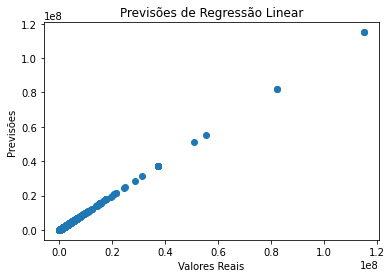

In [51]:
import matplotlib.pyplot as plt

# Extrair as colunas de previsão e rótulo do dataframe de previsões
predictions_col = predictions.select("prediction").toPandas()
label_col = predictions.select("CustAccountBalance").toPandas()

# Plotar as previsões em relação aos valores reais
plt.scatter(label_col, predictions_col)
plt.xlabel("Valores Reais")
plt.ylabel("Previsões")
plt.title("Previsões de Regressão Linear")
plt.show()